#1 Load data

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
import os
import PIL
import time
import random
import concurrent.futures
from tqdm import tqdm
from PIL.ImageDraw import Draw
from datetime import datetime

In [ ]:
!ividia-smi

/bin/bash: ividia-smi: command not found


In [ ]:
%cd /content/drive/MyDrive/Crowd_counting

/content/drive/MyDrive/Crowd_counting


In [ ]:
# !unzip /content/drive/MyDrive/Crowd_counting/crowd_counting_dataset.zip

In [ ]:
filepath = '/content/drive/MyDrive/Crowd_counting/labels.csv'

In [ ]:
data = pd.read_csv(filepath)
data

,id,count
0,1,35
1,2,41
2,3,41
3,4,44
4,5,41
...,...,...
1995,1996,27
1996,1997,27
1997,1998,25
1998,1999,26


#2 Explore data

In [ ]:
def reconstruct_path(image_id: int) -> str:

    image_id = str(image_id).rjust(6, '0')

    return f'./frames/frames/seq_{image_id}.jpg'

In [ ]:
pwd

'/content/drive/MyDrive/Crowd_counting'

In [ ]:
data['image_paths'] = data['id'].apply(reconstruct_path)
data

,id,count,image_paths
0,1,35,./frames/frames/seq_000001.jpg
1,2,41,./frames/frames/seq_000002.jpg
2,3,41,./frames/frames/seq_000003.jpg
3,4,44,./frames/frames/seq_000004.jpg
4,5,41,./frames/frames/seq_000005.jpg
...,...,...,...
1995,1996,27,./frames/frames/seq_001996.jpg
1996,1997,27,./frames/frames/seq_001997.jpg
1997,1998,25,./frames/frames/seq_001998.jpg
1998,1999,26,./frames/frames/seq_001999.jpg


In [ ]:
data.describe()

,id,count
count,2000.000000,2000.000000
mean,1000.500000,31.157500
std,577.494589,6.945417
min,1.000000,13.000000
25%,500.750000,26.000000
50%,1000.500000,31.000000
75%,1500.250000,36.000000
max,2000.000000,53.000000


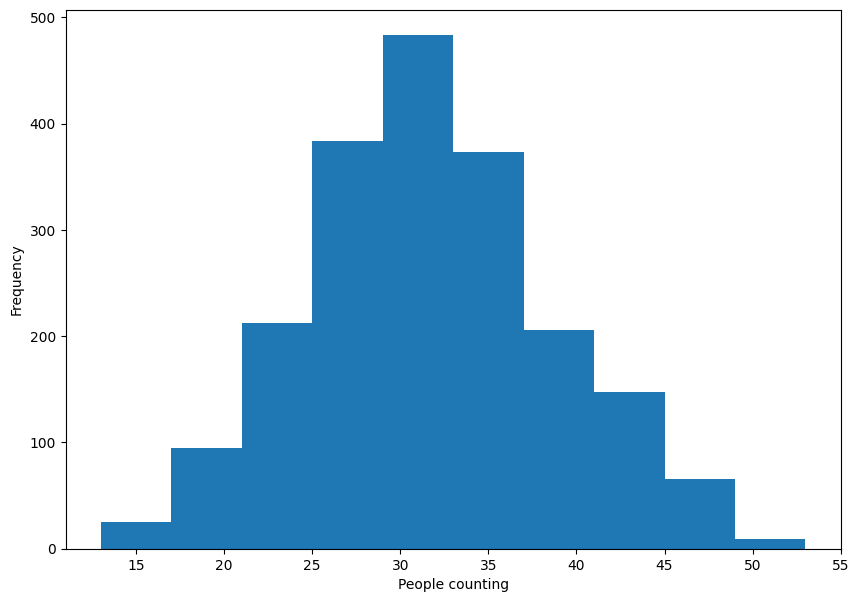

In [ ]:
# Plot the model
plt.figure(figsize=(10,7))
data['count'].plot.hist()
plt.xlabel('People counting')
plt.ylabel('Frequency')
plt.show();

#3 Build model

##3.1 Using out-of-the-box model

In [ ]:
def detect_objects(path: str, model):

    image_tensor = tf.image.decode_jpeg(tf.io.read_file(path), channels=3)[tf.newaxis, ...]

    return model(image_tensor)

In [ ]:
def count_persons(path: str, model, threshold=0.) -> int:
    """Function counts the number of persons in an image
    processing "detection_classes" output of the model
    and taking into account confidence threshold.
    :param path: File path
    :param model: Object detection model
    :param threshold: Threshold for confidence scores
    :return: Number of people for one image
    """
    results = detect_objects(path, model)
    # Class ID 1 = "person"
    return (results['detection_classes'].numpy()[0] == 1)[np.where(
        results['detection_scores'].numpy()[0] > threshold)].sum()

In [ ]:
def draw_bboxes(image_path, data: dict, threshold=0.) -> PIL.Image:
    """Function displays an image with bounding boxes
    overlaid for every detected person.
    :param image_path: File path to an image
    :param data: Output of objects detection model for this image
    :param threshold: Threshold for confidence scores
    :return: PIL.Image object
    """
    image = PIL.Image.open(image_path)
    draw = Draw(image)

    im_width, im_height = image.size

    boxes = data['detection_boxes'].numpy()[0]
    classes = data['detection_classes'].numpy()[0]
    scores = data['detection_scores'].numpy()[0]

    for i in range(int(data['num_detections'][0])):
        if classes[i] == 1 and scores[i] > threshold:
            ymin, xmin, ymax, xmax = boxes[i]
            (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                          ymin * im_height, ymax * im_height)
            draw.line([(left, top), (left, bottom), (right, bottom), (right, top), (left, top)],
                      width=4, fill='red')

    return image

In [ ]:
def set_display():
    """Function sets display options for charts and pd.DataFrames.
    """
    # Plots display settings
    plt.style.use('fivethirtyeight')
    plt.rcParams['figure.figsize'] = 12, 8
    plt.rcParams.update({'font.size': 14})
    # DataFrame display settings
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_rows', None)
    pd.options.display.float_format = '{:.4f}'.format

In [ ]:
# Load the model.
MODEL_PATH = 'https://tfhub.dev/tensorflow/efficientdet/d0/1'
detector = hub.load(MODEL_PATH)

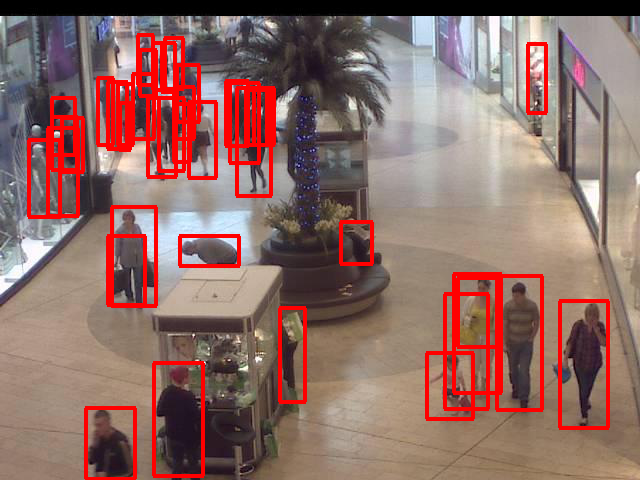

In [ ]:
example_path = './frames/frames/seq_000010.jpg'
results = detect_objects(example_path, detector)
draw_bboxes(example_path, results)

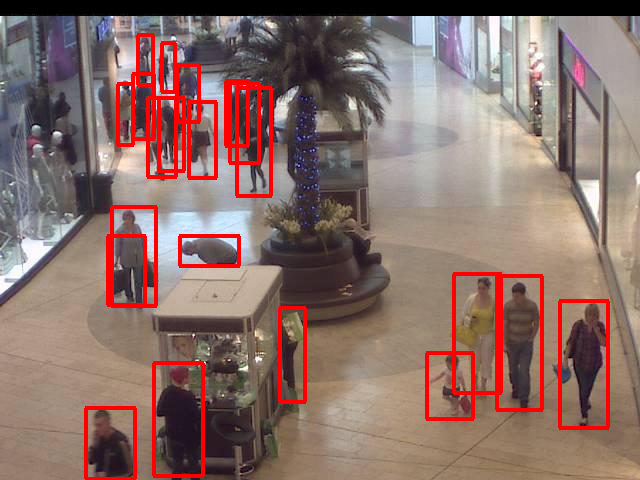

In [ ]:
# Add threshold parameter
draw_bboxes(example_path, results, threshold=0.2)

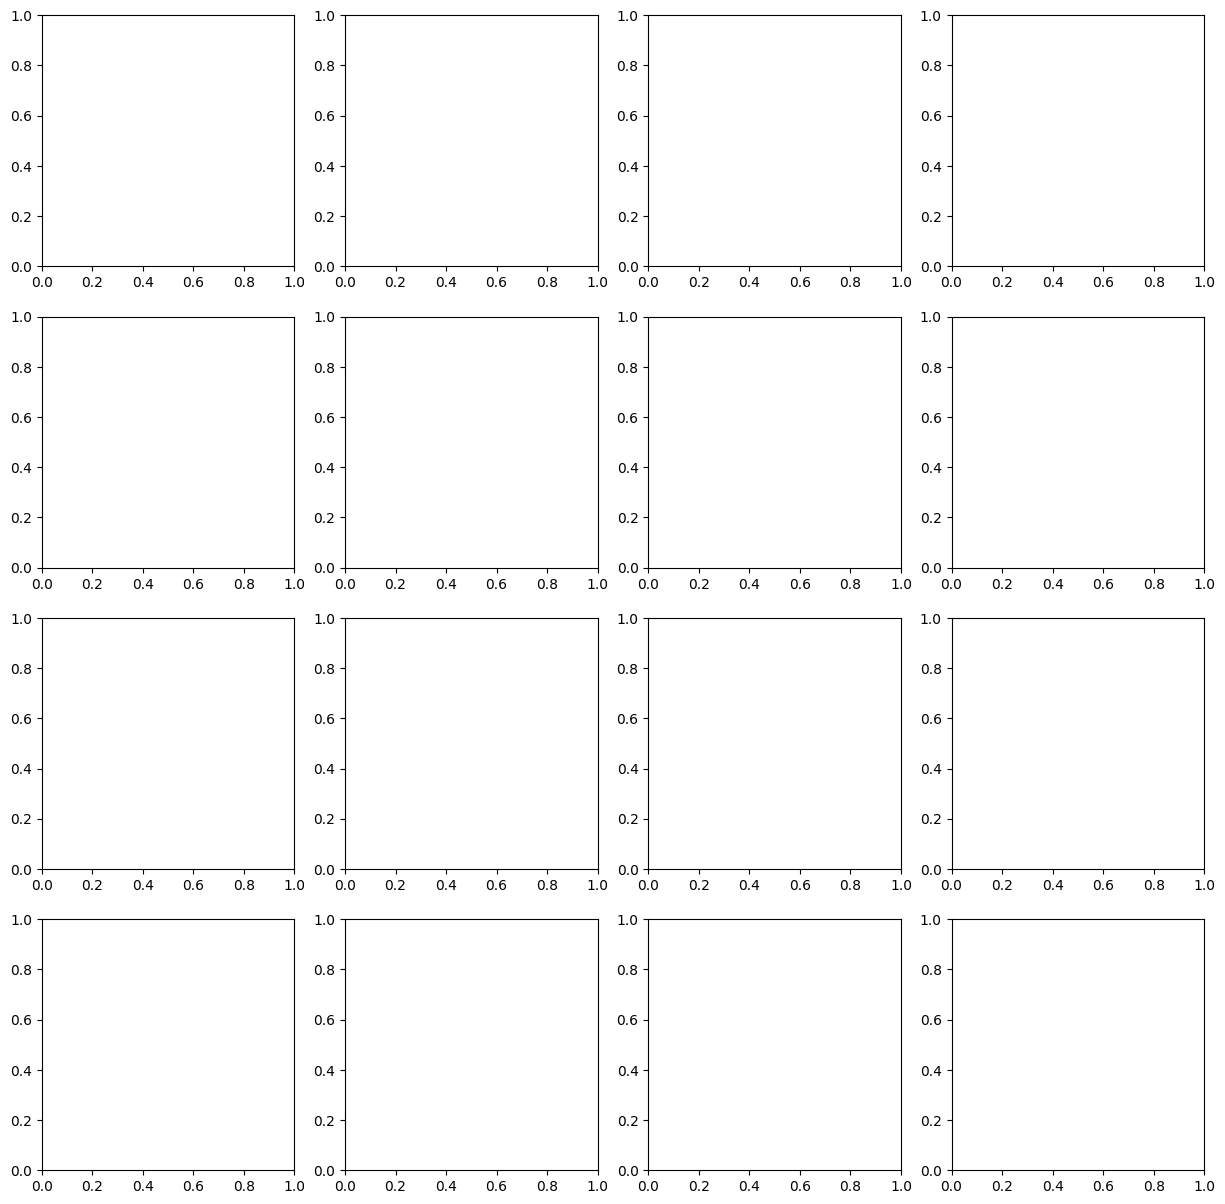

In [ ]:
# Visualizing some images use threshold = 0.2
image_paths = data['image_paths'][:16]
plt.figure(figsize=(15, 15))
for idx, path in enumerate(image_paths):

  # Create subplots 
  ax = plt.subplot(4, 4, idx+1)
  # Display an image with detection
  results = detect_objects(path, detector)
  draw_bboxes(path, results, threshold=0.2)
  # Turn the grid lines off
  # plt.axis("off")

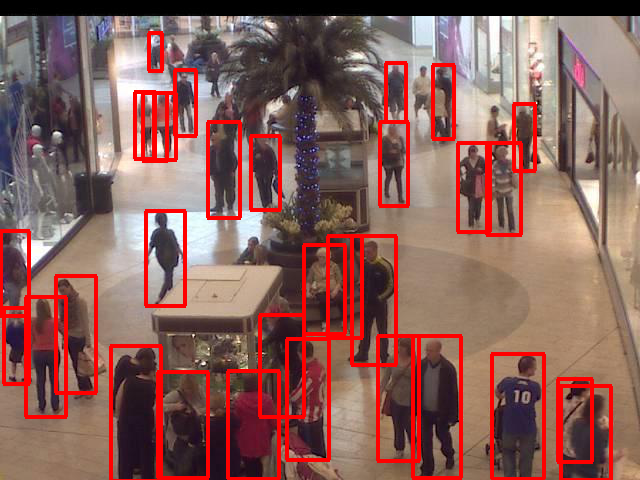

In [ ]:
# Test the model on a very crowded image.
example_path = data.loc[data['count'] == data['count'].max(), 'image_paths'].iloc[0]
results = detect_objects(example_path, detector)
draw_bboxes(example_path, results, threshold=0.2)

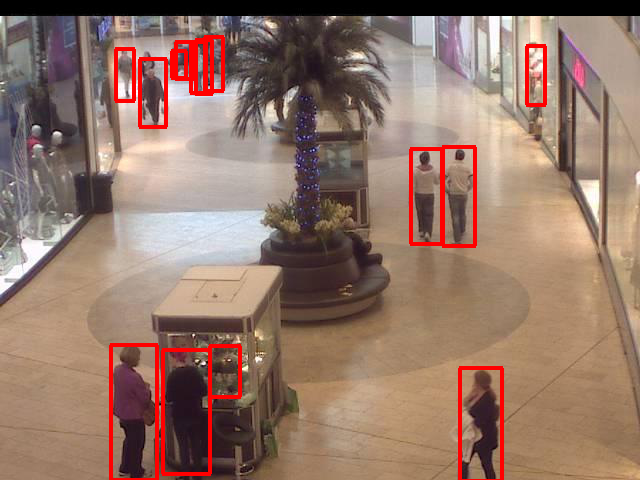

In [ ]:
# Test the model on an image with small number of people
example_path = data.loc[data['count'] == data['count'].min(), 'image_paths'].iloc[0]
results = detect_objects(example_path, detector)
draw_bboxes(example_path, results, threshold=0.2)

In [ ]:
# Randomly selected sample of 200 images (10% of the original data set).
sample = data.sample(frac=0.1)
start = time.perf_counter()
objects = []

# Speed up the model by using multiprocessing
with concurrent.futures.ThreadPoolExecutor() as executor:
  results = [executor.submit(count_persons, path, detector, 0.20) for path in sample['image_paths']]
  for f in tqdm(concurrent.futures.as_completed(results)):
    objects.append(f.result())

finish = time.perf_counter()
print(f'/nFinished in {round(finish - start, 2)} second(s).')

200it [02:27,  1.36it/s]

/nFinished in 147.32 second(s).


In [ ]:
sample['prediction'] = objects
sample.head(10)

,id,count,image_paths,prediction
1211,1212,38,./frames/frames/seq_001212.jpg,13
800,801,34,./frames/frames/seq_000801.jpg,31
43,44,20,./frames/frames/seq_000044.jpg,23
239,240,23,./frames/frames/seq_000240.jpg,17
1326,1327,37,./frames/frames/seq_001327.jpg,17
1263,1264,30,./frames/frames/seq_001264.jpg,21
233,234,34,./frames/frames/seq_000234.jpg,17
1508,1509,20,./frames/frames/seq_001509.jpg,30
1592,1593,28,./frames/frames/seq_001593.jpg,27
547,548,17,./frames/frames/seq_000548.jpg,28


In [ ]:
sample['mae'] = (sample['count']-sample['prediction']).abs()
sample['mse'] = sample['mae'] ** 2

In [ ]:
print(f"mae: {sample['mae'].mean()}") 
print(f"mse: {sample['mse'].mean()}")

mae: 8.775
mse: 114.835


In [ ]:
sample.head()

,id,count,image_paths,prediction,mae,mse
1211,1212,38,./frames/frames/seq_001212.jpg,13,25,625
800,801,34,./frames/frames/seq_000801.jpg,31,3,9
43,44,20,./frames/frames/seq_000044.jpg,23,3,9
239,240,23,./frames/frames/seq_000240.jpg,17,6,36
1326,1327,37,./frames/frames/seq_001327.jpg,17,20,400


<Axes: ylabel='Frequency'>

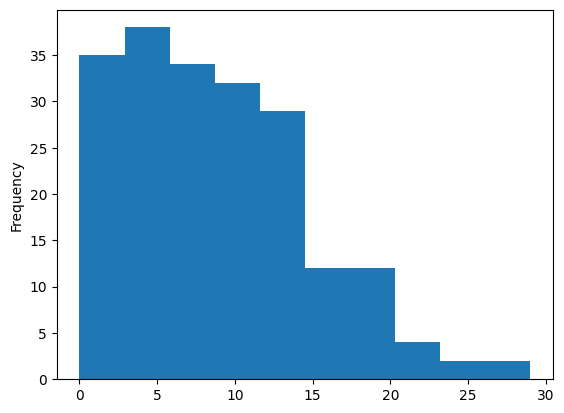

In [ ]:
sample['mae'].plot.hist()

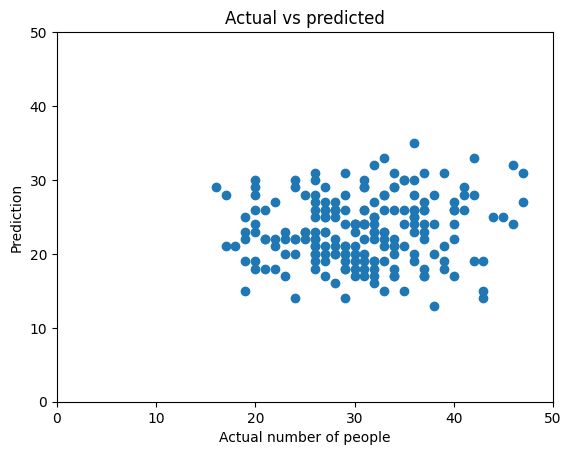

In [ ]:
# Plot the prediction and actual number of people
plt.scatter(sample['count'], sample['prediction'])
plt.xlabel("Actual number of people")
plt.ylabel("Prediction")
plt.title("Actual vs predicted")
plt.xlim(0, 50)
plt.ylim(0,50)
plt.show()

We can see that prediction tend to lower than actual number of people, we can improve prediction by decreasing the threshold

##3.2 Pretrained model: InceptionResNetV2

In [ ]:
# TensorFlow settings and training parameters
AUTOTUNE = tf.data.AUTOTUNE
EPOCHS = 50
BATCH_SIZE = 32
PATIENCE = 5
LEARNING_RATE = 1e-3
IMAGE_SIZE = 299

In [ ]:
def load_image(is_labelled: bool,is_training=True):
    """Wrapper function that returns a function
    for loading a single image if is_labelled=False
    or a function for loading image in an image-label pair
    if is_labelled=True.
    :param is_labelled: Boolean argument defining the return
    :param is_training: Boolean argument for image augmentation
    :return: Function
    """
    def _get_image(path: str) -> tf.Tensor:
        """Function loads image from a file.
        :param path: Path to image file
        :return: Tensor with preprocessed image
        """
        image = tf.image.decode_jpeg(tf.io.read_file(path), channels=3)
        image = tf.cast(image, dtype=tf.int32)
        image = tf.image.resize_with_pad(image, IMAGE_SIZE, IMAGE_SIZE)
        if is_training:
            image = tf.image.random_flip_left_right(image)
            image = tf.image.random_brightness(image, 0.1)
            image = tf.image.random_contrast(image, 0.1, 0.2)
            image = tf.image.random_saturation(image, 0.9, 1.1)
            image = tf.image.random_hue(image, 0.1)
        return tf.keras.applications.inception_resnet_v2.preprocess_input(image)

    def _get_image_label(img: tf.Tensor, label: int):
        """Function loads the image in an image-label pair.
        :param img: Tensor with original image
        :param label: Target value
        :return: Tuple with TF tensor and label
        """
        return _get_image(img), label

    return _get_image_label if is_labelled else _get_image


def prepare_dataset(dataset, is_training=True, is_labeled=True):
    """Function transforms a TF dataset containing file paths
    or file paths and labels to a dataset with image tensors and labels.
    :param dataset: Original dataset
    :param is_training: Argument defines if shuffling and image augmentation should be applied
    :param is_labeled: Argument defines if the dataset contains labels
    :return: Updated dataset
    """
    image_read_fn = load_image(is_labeled, is_training)
    dataset = dataset.map(image_read_fn, num_parallel_calls=AUTOTUNE)
    return dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)


def create_model() -> tf.keras.Model:
    """Function initializes and compiles a regression model
    with pretrained feature extractor.
    :return: TF Model object
    """
    feature_model = tf.keras.applications.InceptionResNetV2(
        include_top=False, pooling='avg')
    feature_model.trainable = False

    model = tf.keras.Sequential([
        tf.keras.Input((IMAGE_SIZE, IMAGE_SIZE, 3)),
        feature_model,
        tf.keras.layers.Dense(512, activation='selu'),
        tf.keras.layers.Dense(1)
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                  loss=tf.keras.losses.MeanSquaredError(),
                  metrics=[tf.keras.metrics.MeanAbsoluteError()])

    return model


def plot_history(hist):
    """Function plots a chart with training and validation metrics.
    :param hist: Tensorflow history object from model.fit()
    """
    mae = hist.history['mean_absolute_error']
    val_mae = hist.history['val_mean_absolute_error']
    x_axis = range(1, len(mae) + 1)
    plt.plot(x_axis, mae, 'bo', label='Training')
    plt.plot(x_axis, val_mae, 'ro', label='Validation')
    plt.title('MAE')
    plt.legend()
    plt.xlabel('Epochs')
    plt.tight_layout()
    plt.show()


In [ ]:
# Create train and validation data sets.
random.seed(42)
train_data = data.head(1700)
val_data = data.tail(300)

train_dataset = tf.data.Dataset.from_tensor_slices((train_data['image_paths'], train_data['count']))
val_dataset = tf.data.Dataset.from_tensor_slices((val_data['image_paths'], val_data['count']))

train_dataset = prepare_dataset(train_dataset)
val_dataset = prepare_dataset(val_dataset, is_training=False)

In [ ]:
# Load the model.
model = create_model()

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=PATIENCE,
    restore_best_weights=True)

lr_reduction = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', patience=1, cooldown=1, verbose=1,
    factor=0.75, min_lr=1e-8)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='/content/drive/MyDrive/Crowd_counting/checkpoint/weights.{epoch:02d}-{val_loss:.2f}',
    monitor='val_loss',
    verbose=1,
    save_best_only=False,
    save_weights_only=True,
    mode='auto',
    save_freq='epoch')

# history = model.fit(train_dataset, validation_data=val_dataset,
#                     epochs=EPOCHS, callbacks=[early_stopping, lr_reduction, checkpoint],
#                     use_multiprocessing=True, workers=os.cpu_count())

Epoch 1/50
54/54 [==============================] - ETA: 0s - loss: 74.6293 - mean_absolute_error: 6.4691 
Epoch 1: saving model to /content/drive/MyDrive/Crowd_counting/checkpoint/weights.01-42.36
54/54 [==============================] - 1226s 22s/step - loss: 74.6293 - mean_absolute_error: 6.4691 - val_loss: 42.3642 - val_mean_absolute_error: 5.6614 - lr: 0.0010
Epoch 2/50
54/54 [==============================] - ETA: 0s - loss: 46.6902 - mean_absolute_error: 5.2897 
Epoch 2: saving model to /content/drive/MyDrive/Crowd_counting/checkpoint/weights.02-29.45
54/54 [==============================] - 1157s 21s/step - loss: 46.6902 - mean_absolute_error: 5.2897 - val_loss: 29.4508 - val_mean_absolute_error: 4.6680 - lr: 0.0010
Epoch 3/50
54/54 [==============================] - ETA: 0s - loss: 37.0853 - mean_absolute_error: 4.7494 
Epoch 3: saving model to /content/drive/MyDrive/Crowd_counting/checkpoint/weights.03-26.11
54/54 [==============================] - 1190s 22s/step - loss: 37.0

In [ ]:
def create_model() -> tf.keras.Model:
    """Function initializes and compiles a regression model
    with pretrained feature extractor.
    :return: TF Model object
    """
    feature_model = tf.keras.applications.InceptionResNetV2(
        include_top=False, pooling='avg')
    feature_model.trainable = False

    model = tf.keras.Sequential([
        tf.keras.Input((IMAGE_SIZE, IMAGE_SIZE, 3)),
        feature_model,
        tf.keras.layers.Dense(512, activation='selu'),
        tf.keras.layers.Dense(1)
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=4.223513315082528e-05),
                  loss=tf.keras.losses.MeanSquaredError(),
                  metrics=[tf.keras.metrics.MeanAbsoluteError()])

    return model

In [ ]:
# Continuously train model from pretrain weights, start by epoch=30
model = create_model()

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=PATIENCE,
    restore_best_weights=True)

lr_reduction = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', patience=1, cooldown=1, verbose=1,
    factor=0.75, min_lr=1e-8)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='/content/drive/MyDrive/Crowd_counting/checkpoint/weights.{epoch:02d}-{val_loss:.2f}',
    monitor='val_loss',
    verbose=1,
    save_best_only=False,
    save_weights_only=True,
    mode='auto',
    save_freq='epoch')

model.load_weights("/content/drive/MyDrive/Crowd_counting/checkpoint/weights.30-18.78")

In [ ]:
prediction = prepare_test_image('./frames/frames/seq_000010.jpg')
draw_bboxes('./frames/frames/seq_000010.jpg', prediction)

In [ ]:
def prepare_test_image(image):
    """Prepares a test image for prediction.
    :param image: Input test image
    :return: Prediction result
    """
    # Load the image using the load_image function with is_labelled=False
    image_fn = load_image(is_labelled=False, is_training=False)
    image = image_fn(image)

    # Expand the dimensions of the image to match the input shape of the model
    image = tf.expand_dims(image, axis=0)

    # Normalize the image
    image = tf.keras.applications.inception_resnet_v2.preprocess_input(image)

    # Get the prediction using the model
    prediction = model.predict(image)

    return prediction


In [ ]:
history_2 = model.fit(train_dataset, validation_data=val_dataset,
                    epochs=70, callbacks=[early_stopping, lr_reduction, checkpoint],
                    initial_epoch=30,
                    use_multiprocessing=True, workers=os.cpu_count())

Epoch 31/70
54/54 [==============================] - ETA: 0s - loss: 17.2922 - mean_absolute_error: 3.3240 
Epoch 31: saving model to /content/drive/MyDrive/Crowd_counting/checkpoint/weights.31-18.68
54/54 [==============================] - 1284s 23s/step - loss: 17.2922 - mean_absolute_error: 3.3240 - val_loss: 18.6774 - val_mean_absolute_error: 3.4928 - lr: 4.2235e-05
Epoch 32/70
54/54 [==============================] - ETA: 0s - loss: 17.6256 - mean_absolute_error: 3.3776 
Epoch 32: saving model to /content/drive/MyDrive/Crowd_counting/checkpoint/weights.32-18.53
54/54 [==============================] - 1222s 23s/step - loss: 17.6256 - mean_absolute_error: 3.3776 - val_loss: 18.5291 - val_mean_absolute_error: 3.4655 - lr: 4.2235e-05
Epoch 33/70
54/54 [==============================] - ETA: 0s - loss: 17.2487 - mean_absolute_error: 3.3220 
Epoch 33: ReduceLROnPlateau reducing learning rate to 3.167634986311896e-05.

Epoch 33: saving model to /content/drive/MyDrive/Crowd_counting/chec

KeyboardInterrupt: ignored